# LangGraph Looping Logic

## Key Concepts

- **Conditional Edges**: These help decide the flow direction based on the current state.
- **Self-loops**: Nodes that loop back to themselves or other nodes to enable iterative behavior.
- **State Management**: Keeps track of data across multiple loop iterations.

We'll showcase two distinct methods for implementing loops in LangGraph:

1. **Direct Conditional Routing**: Utilizing conditional edges straight from a processing node.
2. **Separate Decision Node**: Employing a dedicated node to handle routing decisions.


## Setup and Imports


In [1]:
from langgraph.graph import StateGraph, END
import random
from typing import TypedDict, List
from IPython.display import Image, display

## State Definition

We'll create a simple state that tracks a list of numbers and their running total. Our loop will continue adding random numbers until the total reaches a threshold.


In [2]:
# Define the shape of our state
class SumState(TypedDict):
    numbers: List[int]
    total: int

## Approach 1: Direct Conditional Routing

In this approach, we'll create a graph where the conditional edges are attached directly to the processing node. This creates a more compact graph structure.

### Node Functions


### Building the Graph

Now, we'll build the graph using direct conditional routing. Observe how the `add` node features conditional edges that can loop back to itself, forming a cycle.


### Visualizing the Graph

Let's visualize the graph structure to understand the flow better.


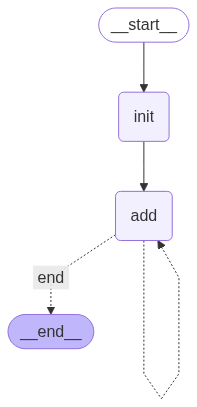

### Running the Graph


Total is 5, adding another number...
Total is 13, adding another number...
Total is 23, adding another number...
Total is 31, adding another number...
Total is 44, adding another number...
Reached total 55. Exiting loop.

Final state:
{'numbers': [5, 8, 10, 8, 13, 11], 'total': 55}


## Approach 2: Separate Decision Node

In this approach, we'll use a dedicated decision node that acts as a router. This pattern separates the processing logic from the routing logic, which can be useful for more complex decision-making scenarios.

### Node Functions


### Building the Graph with Decision Node

This time we'll create a more explicit flow: `init → add → decide → (add or END)`


### Visualizing the Second Graph


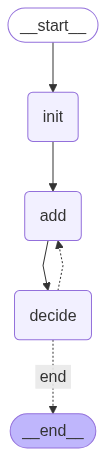

### Running the Second Graph


Total is 15, adding another number...
Total is 28, adding another number...
Total is 39, adding another number...
Total is 49, adding another number...
Reached total 63. Exiting loop.

Final state:
{'numbers': [15, 13, 11, 10, 14], 'total': 63}
